**Indhold**
- Tidsindeksering
- Datetime
- Datoformater
- Grupperinger på tid / reindexing
- Kombinér data på tid

In [4]:
import pandas as pd
import plotnine
plotnine.options.figure_size = (12, 10)

# Tidsserier i pandas

Data med tidsinformation indeholder en række udfordringer ift. både visualisering og databehandling.

- Hvordan forstår Python tid og datoer?
- Hvilken tidsenhed skal der arbejdes med?
- Hvordan undgås for mange unikke værdier i tidsvariablen?

I det følgende ses nærmere på, hvordan man kan arbejde med tidsinformation i Python. Som eksempeldata arbejdes med aktiekursdata for Maersk (A.P. Møller - Mærsk A/S).

**Datasæt: Aktiekurs for Maersk B**

Datasættet "maerskb_price-history_01072021-01092021.csv" indeholder kursinformation for aktien "Maersk B". Data indeholder kursinformation for hver halve time for perioden 1/7/2021-1/9/2021; herunder kurs ved åbning, luk, laveste kurs, højeste kurs samt volumen.

In [3]:
import pandas as pd

maersk = pd.read_csv("https://github.com/CALDISS-AAU/course_ddf/raw/master/datasets/maerskb_price-history_01072021-01092021.csv")
maersk.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume
0,2021-09-01 10:30:00,2021-09-01 10:30:00,18040,-5.0,-0.000277,18055,18015,18080,709
1,2021-09-01 10:00:00,2021-09-01 10:00:00,18045,35.0,0.001943,18025,17985,18120,1144
2,2021-09-01 09:30:00,2021-09-01 09:30:00,18010,140.0,0.007834,17975,17920,18080,2030
3,2021-08-31 17:00:00,2021-08-31 17:00:00,17870,80.0,0.004497,17790,17500,17870,55188
4,2021-08-31 16:30:00,2021-08-31 16:30:00,17790,-45.0,-0.002523,17835,17790,17880,2051


In [21]:
maersk['Local Time']

dtype('O')

## Linjeplots

Tidsserier kan med fordel visualiseres med linjeplots. Linjeplots dannes i `plotnine` med `geom_line`. `plotnine` og `pandas` kan dog give bøvl med datoer og tid, hvis ikke data er korrekt formateret som tid:

C:\programs\Anaconda3\envs\mlbase\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


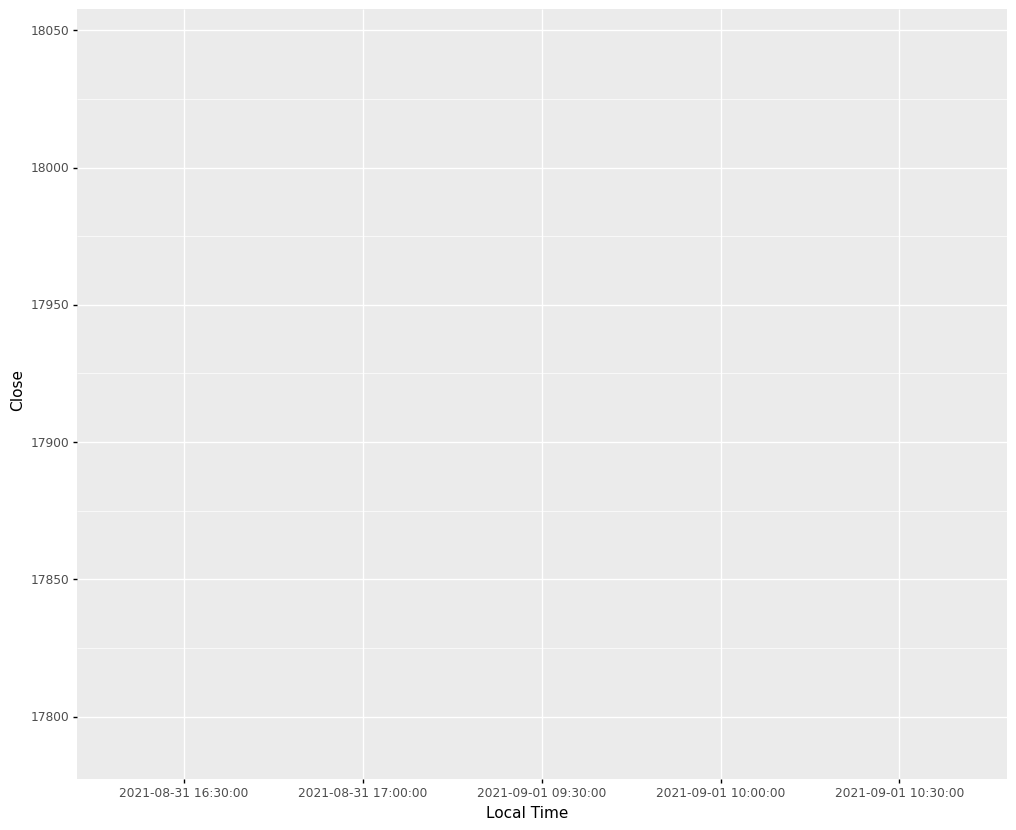

<ggplot: (-9223371889344649012)>

In [22]:
from plotnine import ggplot, aes, geom_line

(ggplot(data = maersk.head(), mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line())

## Konvertering til datetime

Data indeholder tydeligvis tidsinformation i kolonnerne "Local Date" og "Local Time". Python kan bare ikke genkende, at det er dette format:

In [23]:
maersk['Local Time'].dtypes

dtype('O')

For at formatere en kolonne til datoformat, bruges `astype('datetime64')`. Denne konverterer kolonnen til den rette datotype.

In [27]:
maersk['Local Time'] = maersk['Local Time'].astype('datetime64')

Da Python nu kan gende kolonnen som tid, kan linjeplottet laves:

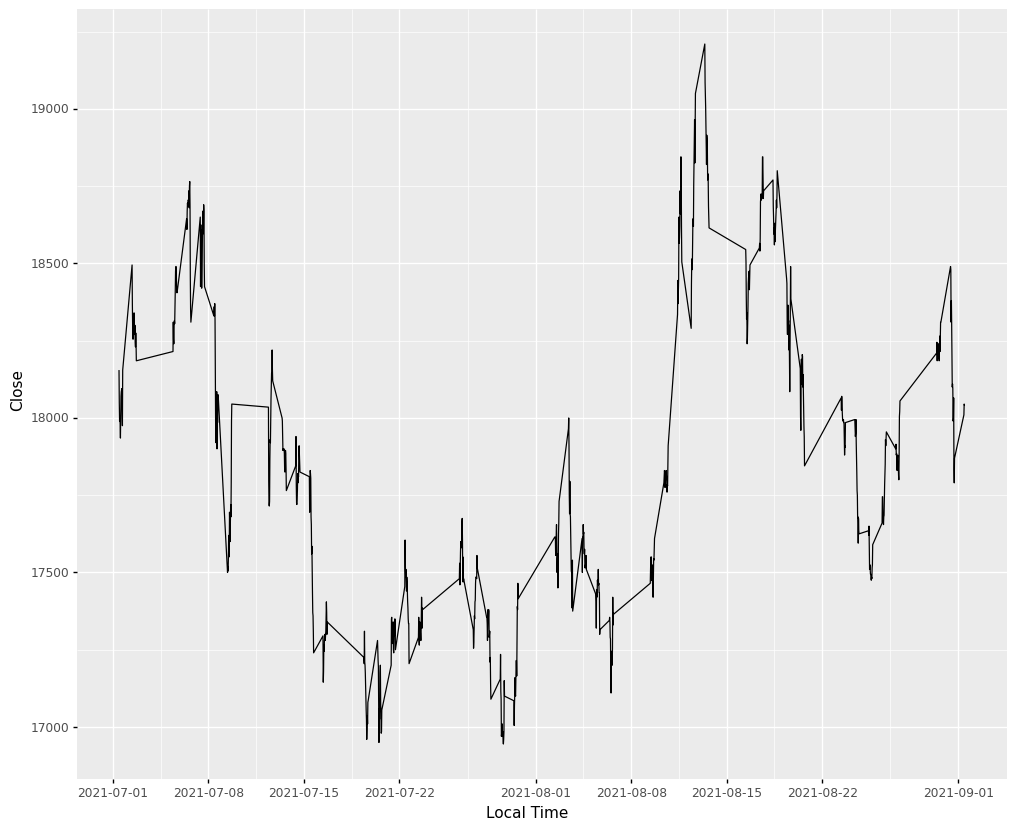

<ggplot: (-9223371889344329404)>

In [29]:
(ggplot(data = maersk, mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line())

## Håndtering af tidsdata

Pandas indeholder en lang række series metoder til at arbejde med datoer og tid ("datetime"). Disse er alle under `.dt`. 

Man er i arbejdet med tidsserier ofte i situationer, hvor man kan have brug for at reducere detaljegraden. Fx er det vanskeligt i det nuværende format at gennemskue hvilken måned, der blev handlet flest aktier. Samtidig kan en visualiseirng også med fordel simplificeres for at gøre den rarere at se på.

Med de forskellige `.dt` metoder, kan man hurtigt danne nye kolonner baseret på en anden frekvens (fx timer, dage, uger, måneder, år). Data kan derefter grupperes og summeres efter disse kolonner. 

Eksempler på `.dt` metoder:

- `dt.year`: År
- `dt.month`: Måned (i tal)
- `dt.day`: Dag
- `dt.hour`: Timetal
- `.dt.date`: Dato
- `.dt.isocalendar().week`: Ugenummer
- `dt.weekday`: Ugedag (i tal)

Man kunne fx undersøge, hvilken dag på ugen, der bliver handlet flest aktier, ved først at lave en kolonne for ugedagen, gruppere på ugedag, danne middel for volumen og visualisere:

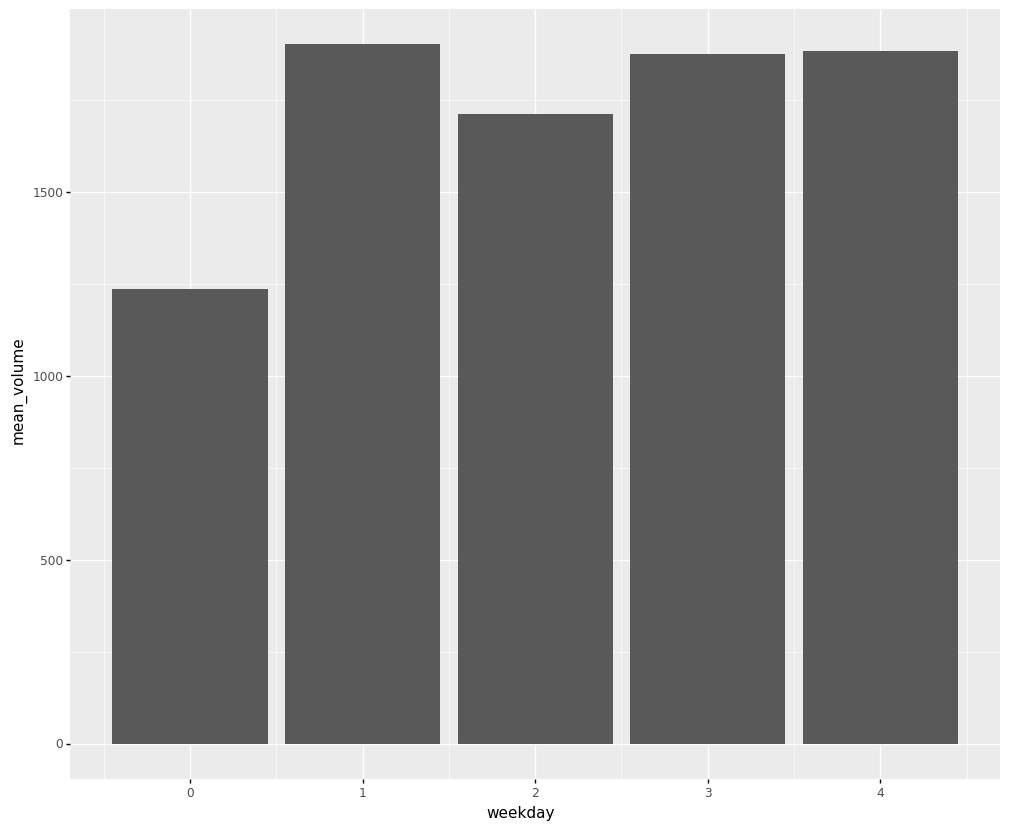

<ggplot: (-9223371889344236780)>

In [45]:
from plotnine import geom_bar

maersk['weekday'] = maersk['Local Time'].dt.weekday
maersk_weektrade = maersk.groupby('weekday')['Volume'].mean().to_frame(name = 'mean_volume').reset_index()

(ggplot(data = maersk_weektrade, mapping = aes(x = 'weekday', y = 'mean_volume'))
 + geom_bar(stat = 'identity')) # stat = identity fortæller at data skal bruges, som det er 

Man kunne også bruge metoderne til at simplificere grafen over lukkekurser en smule:

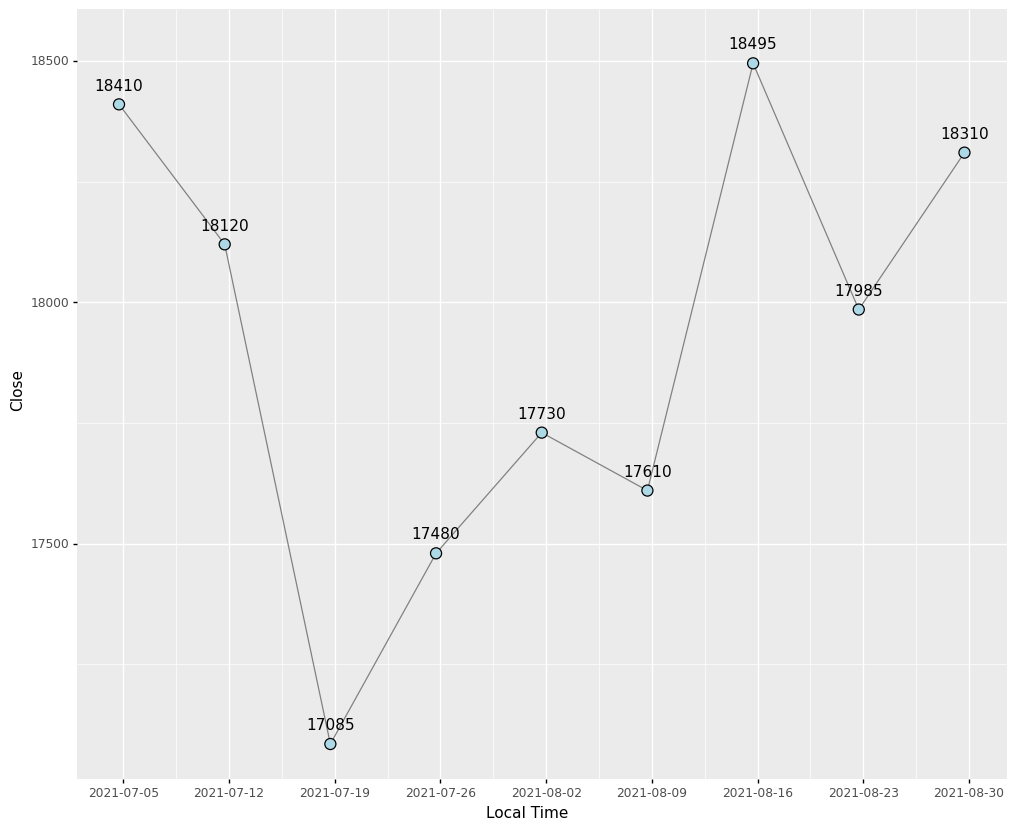

<ggplot: (-9223371889338914188)>

In [101]:
from plotnine import geom_line, geom_point, geom_text, scale_x_date

maersk['date'] = maersk['Local Time'].dt.date
maersk_weekly = maersk.loc[maersk.groupby('date')['Local Time'].idxmax(), :]
maersk_weekly = maersk_weekly.loc[maersk_weekly['weekday'] == 0]

(ggplot(data = maersk_weekly, mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line(color = "grey")
 + geom_point(size = 4, color = "black", fill = "lightblue")
 + geom_text(mapping = aes(label = 'Close'), nudge_y = 40)
 + scale_x_date(date_breaks = "1 week", labels = maersk_weekly['date'].unique()))